In [1]:
%pip install torch torchvision tqdm scikit-learn matplotlib


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [97]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data.dataset import Dataset
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from tqdm.auto import tqdm
from sklearn import metrics
from matplotlib import pyplot as plt

# Membership Inference Attack and Defense on CIFAR-10

**CIFAR-10 Dataset**: CIFAR-10 a benchmark image classification dataset and consists of 60K 32x32 color (RGB) images in 10 different classes, with 6K images per class. It is split into a training set of 50K images and a test set of 10K images. Each image is labeled with one of the following 10 classes:
[0: Airplane, 1: Automobile, 2: Bird, 3: Cat, 4: Deer, **5**: Dog, 6: Frog, 7: Horse, 8: Ship, 9:Truck]


**Train**: the secret dataset that's used to train the target model (not available to the attacker)

**Hold-out**: a dataset that's available to the attacker

**Test**: a dataset used for evaluation of the membership inference attack (not available to the attacker)

In [98]:
# Prepare dataset
cifar10_train = CIFAR10(root='./cifar10', train=True, download=True, transform=ToTensor())
cifar10_test = CIFAR10(root='./cifar10', train=False, download=True, transform=ToTensor())
cifar10_all = ConcatDataset([cifar10_train, cifar10_test])

# train_set: dataset to train target model to be served as a prediction API: not available to attacker
# test_set: dataset to evaluate membership inference attack: not available to attacker
# holdout_set: a dataset available to the attacker

train_set, test_set, holdout_set = random_split(cifar10_all, [.25, .25, .50], generator=torch.Generator().manual_seed(1337))

Files already downloaded and verified
Files already downloaded and verified


In [99]:

class AppendDataset(Dataset):
    '''
    Appends a constant label to all data-points in a dataset.
    '''
    def __init__(self, ds, y):
        self._ds = ds
        self._y = y

    def __getitem__(self, idx):
        x = self._ds[idx]
        return x, self._y

    def __len__(self):
        return len(self._ds)

In [100]:
# Assign True = member  for train set and False = non-member for test set
mia_test_set = ConcatDataset([AppendDataset(train_set, True), AppendDataset(test_set, False)])
mia_test_set_labels = np.array([i[1] for i in mia_test_set])
print (mia_test_set_labels)

[ True  True  True ... False False False]


In [101]:

def get_model():
    model = nn.Sequential(
        nn.Conv2d(3, 32, 3),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(128*2*2, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

    return model

In [102]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [103]:
# define model instance
model = get_model()
model = model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=512, out_features=256, bias=True)
  (14): ReLU()
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): Linear(in_features=128, out_features=10, bias=True)
)


In [105]:
BATCH_SIZE = 50
EPOCHS = 30

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model.train()

losses = []

for epoch in tqdm(range(EPOCHS), postfix='Epoch', leave=False):
    count = 0
    loss_sum = 0
    for data, targets in tqdm(train_loader, leave=False, postfix='Train'):
        optimizer.zero_grad()
        data = data.to(device)
        targets = targets.to(device)
        logits = model(data)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        loss_sum += loss.cpu().detach().numpy()
        count += 1

    losses.append(loss_sum / count)
    #if len(losses) > 2 and losses[-1] > losses[-2] and losses[-2] > losses[-3]:
    #    break

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 67.16it/s, Train]


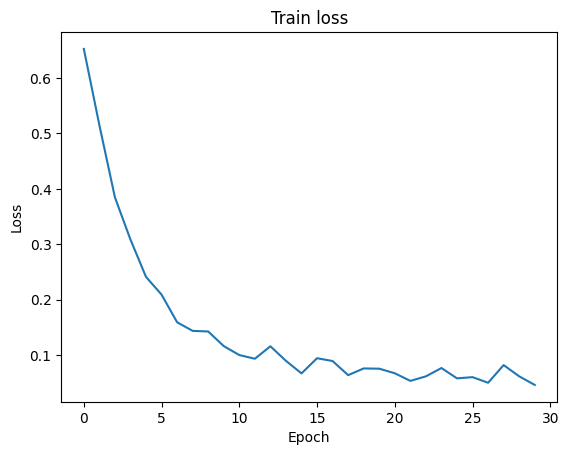

In [106]:
plt.plot(losses)
plt.title('Train loss')
plt.xlabel('Epoch')
_ = plt.ylabel('Loss')

In [107]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

correct = 0

model.eval()

with torch.no_grad():
    for data, targets in tqdm(test_loader, leave=False, postfix='Test'):
        data = data.to(device)
        targets = targets.to(device)
        logits = model(data)
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        preds = np.argmax(probs, axis=1)
        correct += np.sum(preds == targets.cpu().numpy())
acc = correct * 100 / len(test_set)
print(f'Accuracy: {acc:.2f}%')

Accuracy: 66.57%


In [108]:
# save target model
torch.save(model.state_dict(), 'target_model.pt')


In [109]:
# load target model
target_model = get_model()
target_model.load_state_dict(torch.load('target_model.pt'))
target_model.eval()

target_model = target_model.to(device)

In [110]:
# Utilities we need to evaluate our attack

def run_attack(attack, batch_size=50):
    loader = torch.utils.data.DataLoader(mia_test_set, batch_size=batch_size, shuffle=False, pin_memory=True)
    all_preds = []
    for (images, classes), labels in loader:
        with torch.no_grad():
            model_input = images
            model_input = images.to(device)
            target_model_outputs = nn.functional.softmax(target_model(model_input), dim=1)
        preds = attack(images, classes, target_model_outputs)
        if hasattr(preds, 'cpu'):
            preds = preds.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        all_preds.append(preds)
    all_preds = np.concatenate(all_preds)

    return all_preds

def plot_roc(*scores_and_names):
    '''
    Plots ROC curve and computes AUC, given a list of scores and method names.

    Call this function in the format:
     plot_roc(scores1, 'name of attack 1', scores2, 'name of attack 2', ...)
    to compare different attacks.
    '''
    fpr = []
    tpr = []
    for score, name in zip(scores_and_names[::2], scores_and_names[1::2]):
        fpr, tpr, thresholds = metrics.roc_curve(mia_test_set_labels, score)
        auc = metrics.roc_auc_score(mia_test_set_labels, score)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.legend(loc=0)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

def compute_stats(*preds_and_names):
    fpr = []
    tpr = []
    for pred, name in zip(preds_and_names[::2], preds_and_names[1::2]):
        precision = metrics.precision_score(mia_test_set_labels, pred)
        recall = metrics.recall_score(mia_test_set_labels, pred)
        f1 = metrics.f1_score(mia_test_set_labels, pred)
        print(name)
        print(f'  Precision: {precision:.4f}')
        print(f'     Recall: {recall:.4f}')
        print(f'   F1 Score: {f1:.4f}')
        print()

# Membership Inference Attacks
A membership inference attack is implemented as a function that takes in a tensor of data points (floats, [N, C, H, W]), class labels (integer-encoded, [N]), and class probability scores from the black-box target model (floats, [N, 10]), and predicts whether or not they were used in the training set of the target model. The attack can either return an array of booleans or an array of scores. If it returns scores, we can compute ROC and AUC.


In [111]:
def prediction_correctness_mia(x, y, probs):
  #  if prediction is correct (matched ground truth) member, otherwise non-member
  return y == np.argmax(probs.cpu(), axis=1)

In [112]:
preds = run_attack(prediction_correctness_mia)
compute_stats(preds, 'Prediction Correctness')

Prediction Correctness
  Precision: 0.5990
     Recall: 0.9943
   F1 Score: 0.7476



In [113]:
def prediction_loss_mia(x, y, probs):
    # loss is log probability of target class
    # we skip the log because we just want scores, and log is monotonic
    probs = probs.cpu().numpy()
    y = y.numpy()
    return np.array([probs[i][y[i]] for i in range(len(probs))])

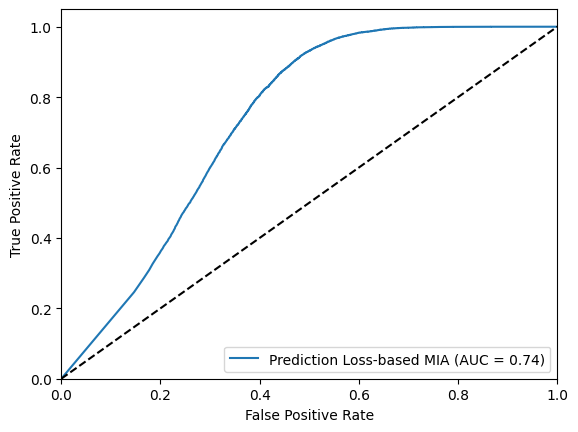

In [114]:
scores_pred_loss = run_attack(prediction_loss_mia)
plot_roc(scores_pred_loss, 'Prediction Loss-based MIA')

In [115]:
def prediction_confidence_mia(x, y, probs):
    probs = probs.cpu().numpy()
    return np.array(np.max(probs, axis=1))

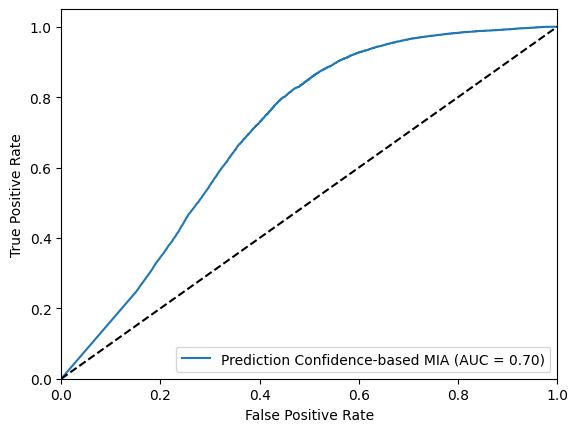

In [116]:
scores_confidence = run_attack(prediction_confidence_mia)
plot_roc(scores_confidence, 'Prediction Confidence-based MIA')

In [117]:
from scipy.stats import entropy

def prediction_entropy_mia(x, y, probs):
    probs = probs.cpu().numpy()
    return np.array([-entropy(dist) for dist in probs])

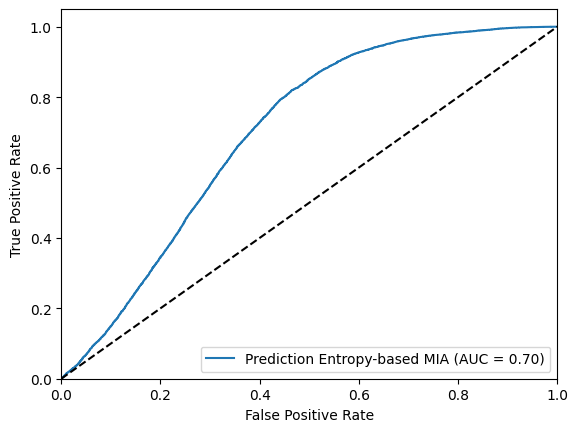

In [118]:
scores_pred_entropy = run_attack(prediction_entropy_mia)
plot_roc(scores_pred_entropy, 'Prediction Entropy-based MIA')

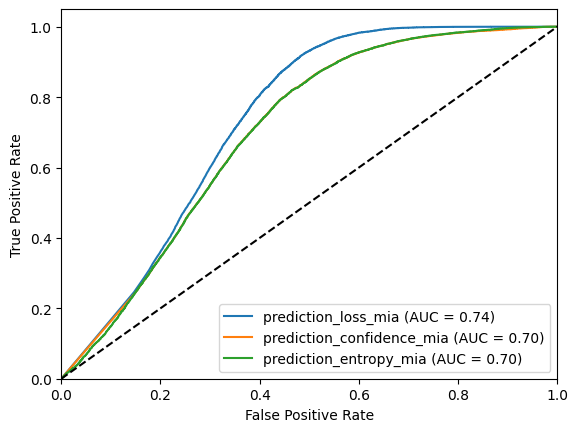

In [119]:
# plot all the three AUCs in one plot
plot_roc(scores_pred_loss, 'prediction_loss_mia', scores_confidence, 'prediction_confidence_mia', scores_pred_entropy,'prediction_entropy_mia')

# Shadow Model Attack
Collect dataset used to train attack model.
We train a number of shadow models on subsets of the hold-out test dataset, to obtain a training dataset for our attack model. This dataset is of the form (label, prediction, used_for_training), with outputs from shadow models on in-sample or out-of-sample data points (all chosen from the hold-out test dataset).

In [120]:
from torchvision.models import resnet18

def train_shadow_model(in_sample):
    model = resnet18()
    model.fc = nn.Linear(512, 10)
    model = get_model()

    model = model.to(device)

    BATCH_SIZE = 50
    MAX_EPOCHS = 20

    train_loader = torch.utils.data.DataLoader(in_sample, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    losses = []

    for epoch in tqdm(range(MAX_EPOCHS), postfix='Epoch', leave=False):
        count = 0
        loss_sum = 0
        for data, targets in tqdm(train_loader, leave=False, postfix='Train'):
            optimizer.zero_grad()
            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            loss_sum += loss.cpu().detach().numpy()
            count += 1
        losses.append(loss_sum / count)
        if len(losses) > 2 and losses[-1] > losses[-2]:
            break # simple early stopping

    return model


In [121]:
def collect_preds(model, ds, batch_size=50):
    loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False, pin_memory=True)
    all_preds = []
    all_labels = []
    for images, labels in loader:
        model_input = images
        model_input = images.to(device)
        with torch.no_grad():
            outputs = nn.functional.softmax(model(model_input))
        all_preds.append(outputs.cpu().detach().numpy())
        all_labels.append(labels.cpu())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

In [122]:
def collect_training_dataset_for_attack_model(model, in_sample, out_of_sample):
    p_in_sample, c_in_sample = collect_preds(model, in_sample)
    l_in_sample = np.array([True for _ in range(len(p_in_sample))], dtype=bool)
    p_out_of_sample, c_out_of_sample = collect_preds(model, out_of_sample)
    l_out_of_sample = np.array([False for _ in range(len(p_out_of_sample))], dtype=bool)

    preds = np.concatenate([p_in_sample, p_out_of_sample])
    classes = np.concatenate([c_in_sample, c_out_of_sample])
    labels = np.concatenate([l_in_sample, l_out_of_sample])

    return preds, classes, labels

In [123]:
NUM_SHADOW_MODELS = 5

probs = []
classes = []
labels = []

for n in tqdm(range(NUM_SHADOW_MODELS), postfix='Shadow Model Number'):
    in_sample, out_of_sample = random_split(holdout_set, [0.5, 0.5])
    model = train_shadow_model(in_sample)
    p, c, l = collect_training_dataset_for_attack_model(model, in_sample, out_of_sample)
    probs.append(p)
    classes.append(c)
    labels.append(l)

probs = np.concatenate(probs)
classes = np.concatenate(classes)
labels = np.concatenate(labels)

  0%|                                                                                                                   | 0/20 [00:00<?, ?it/s, Epoch]

  0%|                                                                                                                  | 0/300 [00:00<?, ?it/s, Train]

  3%|██▊                                                                                                       | 8/300 [00:00<00:04, 71.67it/s, Train]

  5%|█████▌                                                                                                   | 16/300 [00:00<00:03, 75.40it/s, Train]

  8%|████████▊                                                                                                | 25/300 [00:00<00:03, 78.39it/s, Train]

 11%|███████████▌                                                                                             | 33/300 [00:00<00:03, 77.60it/s, Train]

 14%|██████████████▎                                                                    

In [124]:
class AttackDataset(Dataset):
    def __init__(self, probs, classes, labels):
        self._probs = probs
        self._classes = classes
        self._labels = labels

    def __len__(self):
        return len(self._probs)

    def __getitem__(self, idx):
        prob = self._probs[idx]
        cls = self._classes[idx]
        cls_enc = np.zeros(10)
        cls_enc[cls] = 1
        x = np.concatenate([prob, cls_enc])
        y = self._labels[idx]

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        return x, y

In [125]:
attack_set = AttackDataset(probs, classes, labels)


In [126]:
# takes as input, concatenated together:
# - probability distribution (10 floats)
# - class (one-hot encoded, dimension 10)
#
# binary classifier, outputs: distribution over True, False (2 dimensional)

attack_model = nn.Sequential(
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)

In [127]:
BATCH_SIZE = 100
EPOCHS = 20

train_loader = torch.utils.data.DataLoader(attack_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attack_model.parameters())

attack_model.train()

losses = []

for epoch in tqdm(range(EPOCHS), postfix='Epoch', leave=False):
    count = 0
    loss_sum = 0
    for data, targets in tqdm(train_loader, leave=False, postfix='Train'):
        optimizer.zero_grad()
        logits = attack_model(data)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        loss_sum += loss.cpu().detach().numpy()
        count += 1
    losses.append(loss_sum / count)

  0%|                                                                                                                 | 0/1500 [00:00<?, ?it/s, Train]/var/folders/c5/wq017wts7bz1fd_cwqvfxrp40000gq/T/ipykernel_59330/2874012555.py:19: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y = torch.tensor(y, dtype=torch.long)

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1450/1500 [00:01<00:00, 1207.32it/s, Train]


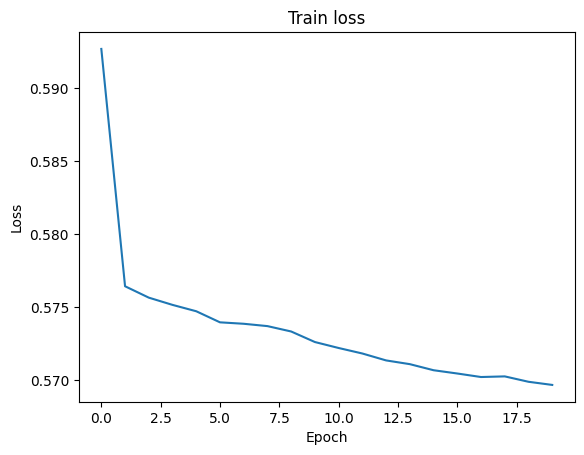

In [128]:
plt.plot(losses)
plt.title('Train loss')
plt.xlabel('Epoch')
_ = plt.ylabel('Loss')


In [129]:
attack_model.eval()

Sequential(
  (0): Linear(in_features=20, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=2, bias=True)
)

In [130]:
def shadow_model_attack(x, y, probs):
    X = torch.cat([
        probs.cpu(),
        nn.functional.one_hot(y, num_classes=10),
    ], dim=1)

    pred_probs = attack_model(X)
    return pred_probs[:, 1].cpu().detach().numpy()


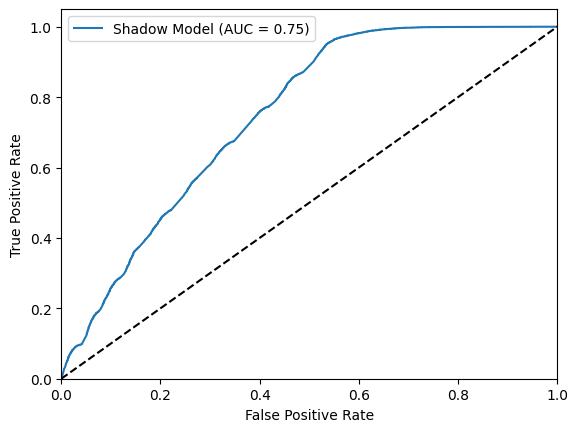

In [131]:
scores = run_attack(shadow_model_attack)
plot_roc(scores, 'Shadow Model')

# DP-SGD: Differentially Private Stochastic Gradient Descent

## Important Hyperparameters
- **Max Grad Norm**: The maximum L2 norm of per-sample gradients before they are aggregated by the averaging step.

- **Noise Multiplier**: The amount of noise sampled and added to the average of the gradients in a batch.

- **Delta**: The target δ of the (ϵ,δ)-differential privacy guarantee. Generally, it should be set to be less than the inverse of the size of the training dataset. In this tutorial, it is set to $10^{−5}$ as the CIFAR10 dataset has 50,000 training points.

In [52]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine

In [ ]:
# Load CIFAR-10 dataset and create DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=50, shuffle=True, pin_memory=True)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=50, shuffle=True, pin_memory=True)

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


In [ ]:

def get_model():
    model = nn.Sequential(
        nn.Conv2d(3, 32, 3),
        nn.ReLU(),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        #nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(128*2*2, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

    return model

In [ ]:
# define model instance
model1 = get_model()
model1 = model1.to(device)
#print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters())

In [ ]:
def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute loss
        pred = model(X)
        loss = criterion(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_func):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
# Train and test non-private model
epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model1, criterion, optimizer)
    test(test_loader, model1, criterion)
print("Done!")

In [ ]:
# Set privacy parameters
epsilon = 1.0
delta = 1e-5
max_per_sample_grad_norm = 1.0
epochs = 20


In [ ]:
# Wrap the DataLoader with Opacus's Privacy Engine
privacy_engine = PrivacyEngine()

model1, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model1.train(),
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=epochs,
    target_epsilon=epsilon,
    target_delta=delta,
    max_grad_norm = max_per_sample_grad_norm,
    )

In [ ]:
# Train and test private-model 
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model1, criterion, optimizer)
    test(test_loader, model1, criterion)
print("Done!")